# 2. Analysis

## Setup

Run the data_cleaning notebook tho have access to all its contents in this shell

In [109]:
# We need to run the data_cleaning notebook this way to have 
# access to the tokenize_review function for the logistic regression

%run 1_data_cleaning.ipynb

Requirement already up-to-date: scikit-learn in /Users/sylvain/anaconda3/envs/optimize/lib/python3.7/site-packages (0.22)
Requirement already up-to-date: spacy in /Users/sylvain/anaconda3/envs/optimize/lib/python3.7/site-packages (2.2.3)
Requirement already up-to-date: pandas in /Users/sylvain/anaconda3/envs/optimize/lib/python3.7/site-packages (0.25.3)
Requirement already up-to-date: seaborn in /Users/sylvain/anaconda3/envs/optimize/lib/python3.7/site-packages (0.9.0)
Requirement already up-to-date: sklearn in /Users/sylvain/anaconda3/envs/optimize/lib/python3.7/site-packages (0.0)
Requirement already up-to-date: nltk in /Users/sylvain/anaconda3/envs/optimize/lib/python3.7/site-packages (3.4.5)
Requirement already up-to-date: jupyter in /Users/sylvain/anaconda3/envs/optimize/lib/python3.7/site-packages (1.0.0)


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


[nltk_data] Downloading package words to /Users/sylvain/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [59]:
plt.rcParams['figure.figsize'] = [10, 7]

## 2.1 EDA

### Import dataset

In [60]:
data = pd.read_csv("../data/very_clean_dataset.csv") 

# Keep the first 100 elements to reduce the load on cpu

data.head()

,review,sentiment,mastacleaned_reviews
0,reviewer mention watch oz episode hook right e...,positive,reviewer mention watch episode hook right exac...
1,wonderful little production filming technique ...,positive,wonderful little production technique very ver...
2,think wonderful way spend time hot sit air con...,positive,think wonderful way spend time hot sit air con...
3,basically family little boy jake think zombie ...,negative,basically family little boy jake think zombie ...
4,petter love time money visually stunning film ...,positive,petter love time money visually stunning film ...


In [61]:
# Base rate, delete later
a=data[data["sentiment"]=="positive"].shape
b=data[data["sentiment"]=="negative"].shape
base_rate=max(a[0], b[0])/data.shape[0]
print("The base rate is "+ str(base_rate))

The base rate is 0.54


## 2.2 Models

#### Splitting the dataset into training and test sets

In [62]:
X = data['review'] # the features we want to analyze, we can play with others too
y = data['sentiment'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

### 2.2.1 Logistic Model

In [63]:
classifier = LogisticRegression(solver="lbfgs")

count_vector = CountVectorizer(tokenizer = tokenize_review, ngram_range = (1,2))

# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', count_vector), ('classifier', classifier)])

# Fit Model
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize_review at 0x12bde9b70>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
            

### Strongest Coefficients

In [64]:
def get_interesting_features(features):
    interesting_coefs = []
    for best_positive in sorted(features.items(), key=lambda x: x[1], reverse=True)[:5]:
        interesting_coefs.append(best_positive)

    for best_negative in sorted(features.items(), key=lambda x: x[1])[:5]:
        interesting_coefs.append(best_negative)
    return interesting_coefs

In [65]:
def graph_interesting_features(interesting_features):
    sorted_by_coef = sorted(interesting_features, key=lambda tup: tup[1], reverse=True)

    feature = [elem[0] for elem in sorted_by_coef]
    coef = [elem[1] for elem in sorted_by_coef]

    plt.bar(feature, coef)
    plt.xticks(feature, fontsize=12)
    plt.xticks(rotation=30)
    plt.show()

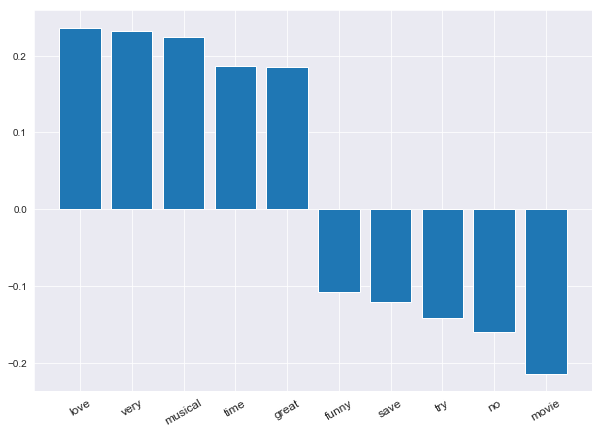

In [66]:
model_features = {
    word: coef for word, coef in zip(
        count_vector.get_feature_names(), classifier.coef_[0]
    )
}

interesting_features = get_interesting_features(model_features)
graph_interesting_features(interesting_features)

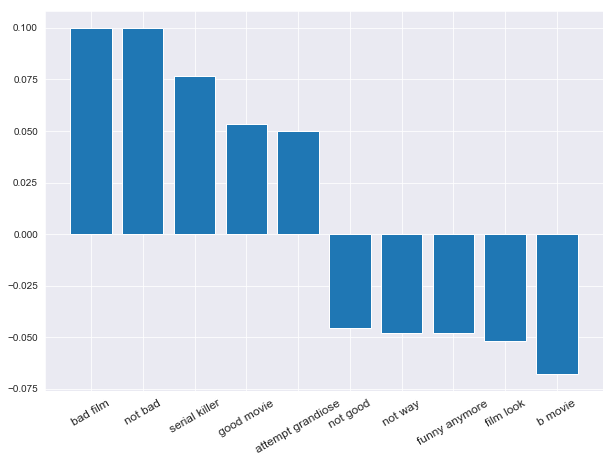

In [67]:
two_gram_features = {key: model_features[key] for key in model_features.keys() if len(key.split(' ')) == 2}
intersting_features = get_interesting_features(two_gram_features)
graph_interesting_features(intersting_features)

#### Results

In [68]:
predicted_train = pipe.predict(X_train)
predicted_test = pipe.predict(X_test)

# train accuracy
print("Train set accuracy: " + str(pipe.score(X_train, y_train)))
# test accuracy
print("Test set accuracy is: " + str(pipe.score(X_test, y_test)))
print("Train set precision: " + str(metrics.precision_score(y_train, predicted_train, pos_label="positive")))
print("Train set recall: " +  str(metrics.recall_score(y_train, predicted_train, pos_label="positive")))
print("Test set precision: " + str(metrics.precision_score(y_test, predicted_test, pos_label="positive")))
print("Test set recall: " + str(metrics.recall_score(y_test, predicted_test, pos_label="positive")))

Train set accuracy: 1.0
Test set accuracy is: 0.5
Train set precision: 1.0
Train set recall: 1.0
Test set precision: 1.0
Test set recall: 0.16666666666666666


#### Confusion matrix

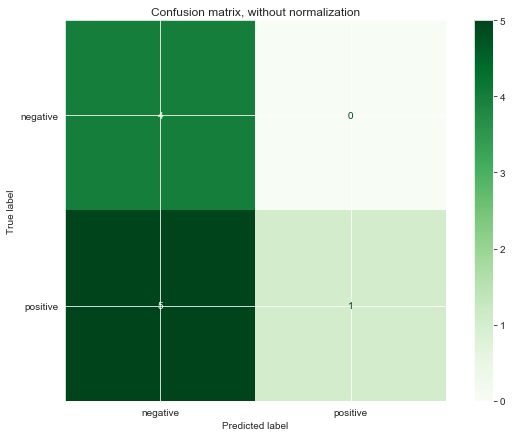

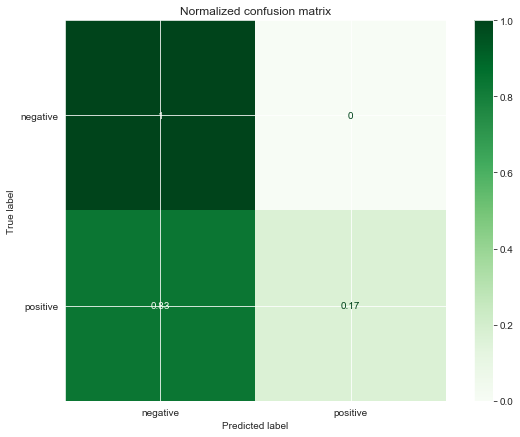

In [69]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(pipe, X_test, y_test, cmap=plt.cm.Greens, normalize=normalize)
    disp.ax_.set_title(title)

#### Precision Recall Curve


Average precision-recall score: 0.84


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.84')

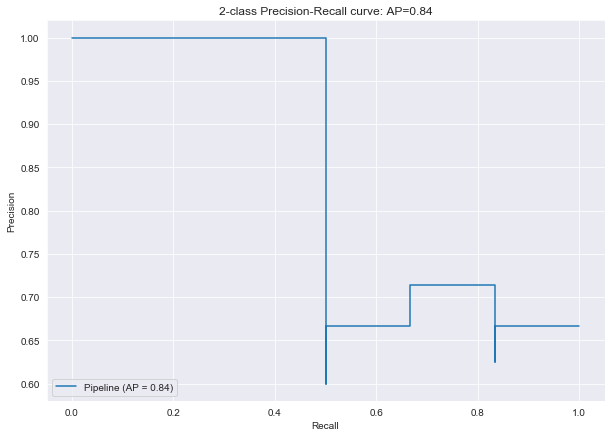

In [70]:
y_score = pipe.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score, pos_label="positive")

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(pipe, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

### 2.2.2 Decision Trees

In [100]:
X = count_vector.fit_transform(data['review'])
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

In [105]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=10)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [106]:
tree.score(X_test,y_test)

0.4

In [107]:
tree.get_depth()

5

#### Tuning the depth of the tree

In [75]:
scores = []
for d in range(1, 21):
    test_tree = DecisionTreeClassifier(criterion='entropy', max_depth=d)
    test_tree.fit(X_train, y_train)
    scores.append(test_tree.score(X_test, y_test))

Text(0.5, 0, 'depth')

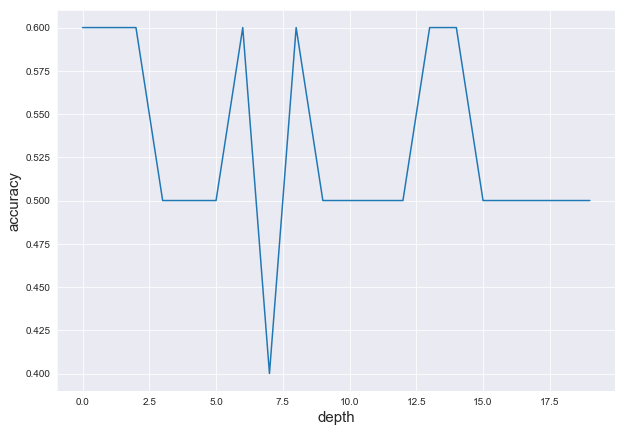

In [76]:
plt.plot(scores)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('depth', fontsize=15)

[Text(251.10000000000002, 199.32, 'X[3146] <= 0.5\nentropy = 0.984\nsamples = 40\nvalue = [23, 17]'),
 Text(209.25, 163.07999999999998, 'X[3199] <= 0.5\nentropy = 0.824\nsamples = 31\nvalue = [23, 8]'),
 Text(167.4, 126.83999999999999, 'X[1932] <= 0.5\nentropy = 0.677\nsamples = 28\nvalue = [23, 5]'),
 Text(125.55000000000001, 90.6, 'X[6211] <= 0.5\nentropy = 1.0\nsamples = 10\nvalue = [5, 5]'),
 Text(83.7, 54.359999999999985, 'X[6001] <= 0.5\nentropy = 0.863\nsamples = 7\nvalue = [5, 2]'),
 Text(41.85, 18.119999999999976, 'entropy = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(125.55000000000001, 18.119999999999976, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(167.4, 54.359999999999985, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(209.25, 90.6, 'entropy = 0.0\nsamples = 18\nvalue = [18, 0]'),
 Text(251.10000000000002, 126.83999999999999, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(292.95, 163.07999999999998, 'entropy = 0.0\nsamples = 9\nvalue = [0, 9]')]

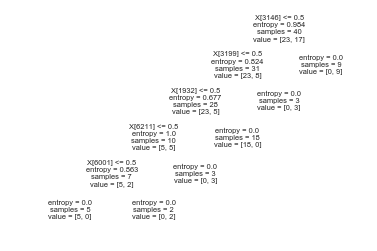

In [110]:
from sklearn.tree import plot_tree

plot_tree(tree)

#### Confusion matrix

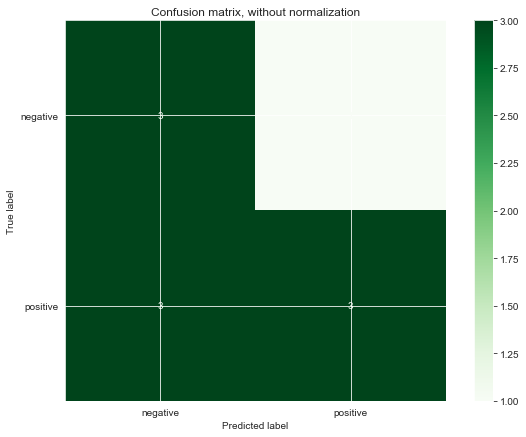

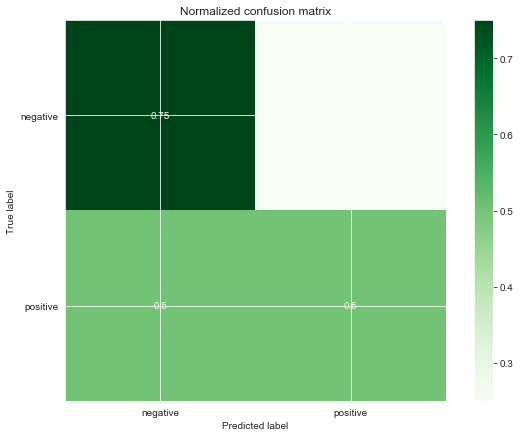

In [78]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(tree, X_test, y_test, cmap=plt.cm.Greens, normalize=normalize)
    disp.ax_.set_title(title)

 We need to have: 
* Precision & Recall for all methods 
* Precision-Recall curve 
* Cross-validation for all methods 


###  2.2.3 KNN Classification

In [89]:
knn = KNeighborsClassifier(n_neighbors= 10, weights='uniform')

In [90]:
X = count_vector.fit_transform(data['review'])
y = data['sentiment']

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

In [92]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [93]:
knn.score(X_test, y_test)

0.4

#### Tuning the value of n

In [96]:
scores = []
for n in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=n, weights='uniform')
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

Text(0.5, 0, 'N')

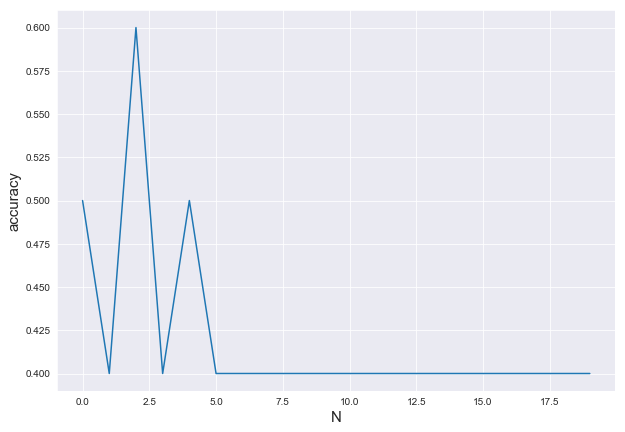

In [98]:
plt.plot(scores)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('N', fontsize=15)

#### Confusion matrix

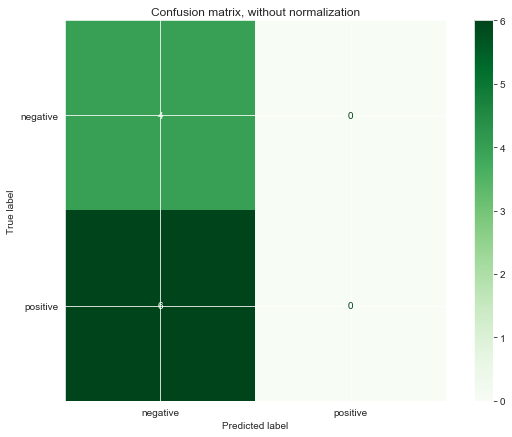

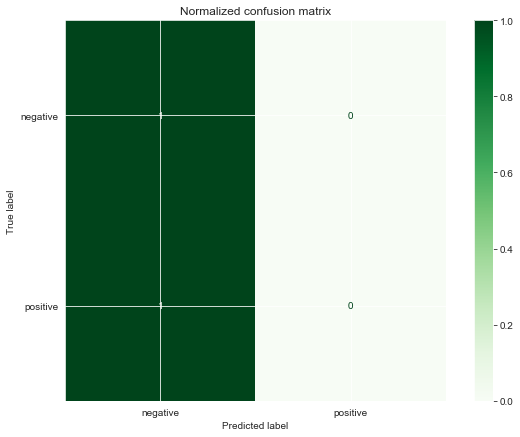

In [84]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Greens, normalize=normalize)
    disp.ax_.set_title(title)

### 2.2.4 Text similarity

In [85]:
stopwords = spacy_stopwords

# using default tokenizer 
count = CountVectorizer(ngram_range=(1,2), stop_words = None)
bow = count.fit_transform(data)

# 2.3. Conclusion and Recommendation

From the analysis shown above we can see that the best performing method of classification of the reviews into binary class positive/negative is Logistic Regression method......